In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D,
                                     LayerNormalization, MaxPooling2D, Reshape, MultiHeadAttention,
                                     GlobalAveragePooling1D, Flatten, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# --- Paths và tham số ---
root_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed/"
paths = [
    os.path.join(root_dir, "im_Dyskeratotic", "im_Dyskeratotic", "CROPPED"),
    os.path.join(root_dir, "im_Koilocytotic", "im_Koilocytotic", "CROPPED"),
    os.path.join(root_dir, "im_Metaplastic", "im_Metaplastic", "CROPPED"),
    os.path.join(root_dir, "im_Parabasal", "im_Parabasal", "CROPPED"),
    os.path.join(root_dir, "im_Superficial-Intermediate", "im_Superficial-Intermediate", "CROPPED")
]

height, width, channels = 64, 64, 3
num_classes = len(paths)

# --- Load dữ liệu ---
def load_images_from_paths(paths, img_size=(height, width)):
    images = []
    labels = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    for idx, p in enumerate(paths):
        if not os.path.exists(p):
            print(f"Warning: path not found {p}")
            continue
        for file in os.listdir(p):
            if not file.lower().endswith(valid_extensions):
                continue
            try:
                img_path = os.path.join(p, file)
                img = Image.open(img_path).convert('RGB').resize(img_size)
                img = np.array(img).astype(np.float32) / 255.0
                if img.shape != (height, width, channels):
                    continue
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Failed loading {file}: {e}")
                continue
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

data, labels = load_images_from_paths(paths)
labels_one_hot = tf.one_hot(labels, depth=num_classes).numpy()

X_train, X_tmp, y_train, y_tmp = train_test_split(
    data, labels_one_hot, test_size=0.3, random_state=, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=19, stratify=np.argmax(y_tmp, axis=1))

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# --- Positional Encoding ---
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# --- Transformer Block ---
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# --- Conv + Multi-head attention block (CMT Block) ---
class CMTBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, conv_kernel=3, rate=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.conv_kernel = conv_kernel
        self.rate = rate
        
        # Convolution branch
        self.conv = Conv2D(embed_dim, conv_kernel, padding='same', activation='relu')
        self.norm1 = LayerNormalization(epsilon=1e-6)
        
        # Transformer branch
        self.flatten_to_seq = Reshape((-1, embed_dim))  # flatten H*W to sequence
        self.pos_encoding = PositionalEncoding(position=height*width, d_model=embed_dim)
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.norm3 = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(rate)

    def call(self, inputs, training=None):
        # Conv branch
        x = self.conv(inputs)
        x = self.norm1(x)
    
        # Transformer branch
        seq = self.flatten_to_seq(x)  # [batch, seq_len, embed_dim]
        seq = self.pos_encoding(seq)
    
        attn_out = self.mha(seq, seq)
        attn_out = self.dropout(attn_out, training=training)
        out1 = self.norm2(seq + attn_out)
    
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout(ffn_out, training=training)
        seq_out = self.norm3(out1 + ffn_out)
    
        # Lấy kích thước H, W động
        B = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        x_out = tf.reshape(seq_out, (B, H, W, -1))
    
        # Residual add conv and transformer features
        return x + x_out
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "conv_kernel": self.conv_kernel,
            "rate": self.rate
        })
        return config


# --- CMT Model ---
def create_cmt_model(input_shape=(height, width, channels), num_classes=num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = MaxPooling2D()(x)
    
    x = CMTBlock(embed_dim=64, num_heads=4, ff_dim=128)(x)
    x = MaxPooling2D()(x)
    
    x = CMTBlock(embed_dim=128, num_heads=4, ff_dim=256)(x)
    x = MaxPooling2D()(x)
    
    x = GlobalAveragePooling2D()(x)
    features = Dense(256, activation='relu', name="features")(x)
    x = Dropout(0.3)(features)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = create_cmt_model()

# --- Train Model ---
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_cmt_lr_model_V6.keras", save_best_only=True, monitor="val_accuracy"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8),
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=200,
    callbacks=callbacks
)

model.load_weights("best_cmt_lr_model_V6.keras")

# --- Extract features for Logistic Regression ---
feature_extractor = Model(inputs=model.input, outputs=model.get_layer("features").output)
train_features = feature_extractor.predict(X_train)
val_features = feature_extractor.predict(X_val)
test_features = feature_extractor.predict(X_test)

y_train_lr = np.argmax(y_train, axis=1)
y_val_lr = np.argmax(y_val, axis=1)
y_test_lr = np.argmax(y_test, axis=1)

# --- Train Logistic Regression ---

lr_model = LogisticRegression(
    max_iter=200,       # Số vòng lặp tối đa
    random_state=42,    # Đảm bảo tái lập kết quả
    solver='saga',      # Bộ giải
    multi_class='multinomial'  # Xử lý phân loại nhiều lớp
)
lr_model.fit(train_features, y_train_lr)

# --- Evaluate Logistic Regression ---
val_preds_lr = lr_model.predict(val_features)
test_preds_lr = lr_model.predict(test_features)

# --- Print Evaluation Metrics ---
print("Validation Accuracy (Logistic Regression):", accuracy_score(y_val_lr, val_preds_lr))
print("Test Accuracy (Logistic Regression):", accuracy_score(y_test_lr, test_preds_lr))
print("Classification Report (Logistic Regression):\n", classification_report(y_test_lr, test_preds_lr))

Epoch 1/200
45/45 [==============================] - 23s 256ms/step - loss: 1.3702 - accuracy: 0.4340 - val_loss: 1.1672 - val_accuracy: 0.5321
Epoch 2/200
45/45 [==============================] - 11s 238ms/step - loss: 1.0821 - accuracy: 0.5554 - val_loss: 1.0308 - val_accuracy: 0.5848
Epoch 3/200
45/45 [==============================] - 11s 241ms/step - loss: 0.9560 - accuracy: 0.6344 - val_loss: 0.9018 - val_accuracy: 0.6672
Epoch 4/200
45/45 [==============================] - 11s 248ms/step - loss: 0.8122 - accuracy: 0.7096 - val_loss: 0.9724 - val_accuracy: 0.5964
Epoch 5/200
45/45 [==============================] - 12s 258ms/step - loss: 0.7591 - accuracy: 0.7223 - val_loss: 0.6913 - val_accuracy: 0.7479
Epoch 6/200
45/45 [==============================] - 12s 263ms/step - loss: 0.6645 - accuracy: 0.7608 - val_loss: 0.6406 - val_accuracy: 0.7661
Epoch 7/200
45/45 [==============================] - 12s 270ms/step - loss: 0.6106 - accuracy: 0.7812 - val_loss: 0.7448 - val_accuracy:

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


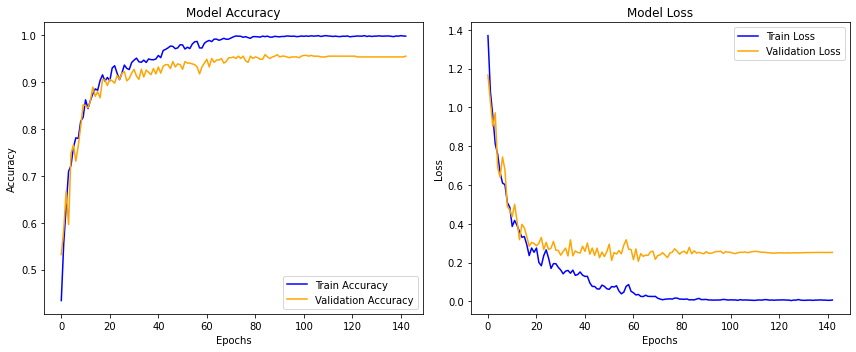

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Visualize Training History ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()




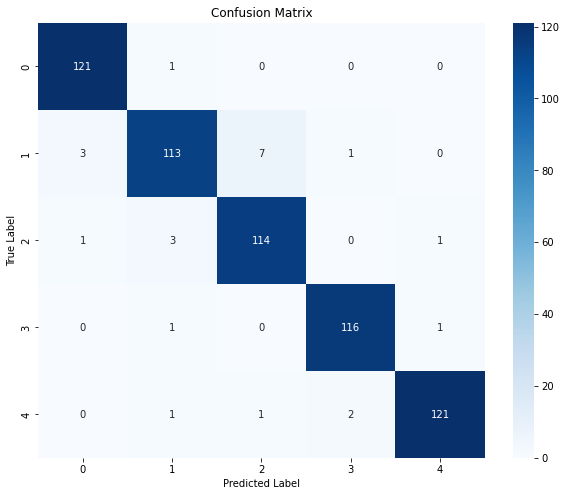

In [4]:
# Số lớp từ dữ liệu
num_classes = y_train.shape[1]

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test_lr, test_preds_lr)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


10 Test Predictions vs Actual Labels:
Prediction: 2, Actual: 2
Prediction: 3, Actual: 3
Prediction: 4, Actual: 4
Prediction: 1, Actual: 1
Prediction: 4, Actual: 4
Prediction: 2, Actual: 2
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 4, Actual: 4


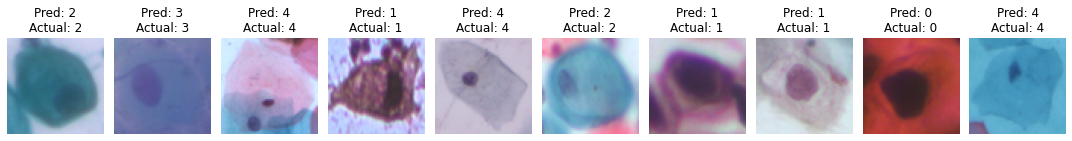

In [5]:
# --- Display 10 Predictions vs Actual Labels ---
print("10 Test Predictions vs Actual Labels:")
for i in range(10):
    print(f"Prediction: {test_preds_lr[i]}, Actual: {y_test_lr[i]}")

# --- Display Images with Predictions and Actual Labels ---
def display_images_with_predictions(X_test, y_test_pred, y_test_int, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test[i].squeeze(), cmap='gray')  
        plt.title(f"Pred: {y_test_pred[i]}\nActual: {y_test_int[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call function to display images
display_images_with_predictions(X_test, test_preds_lr, y_test_lr)

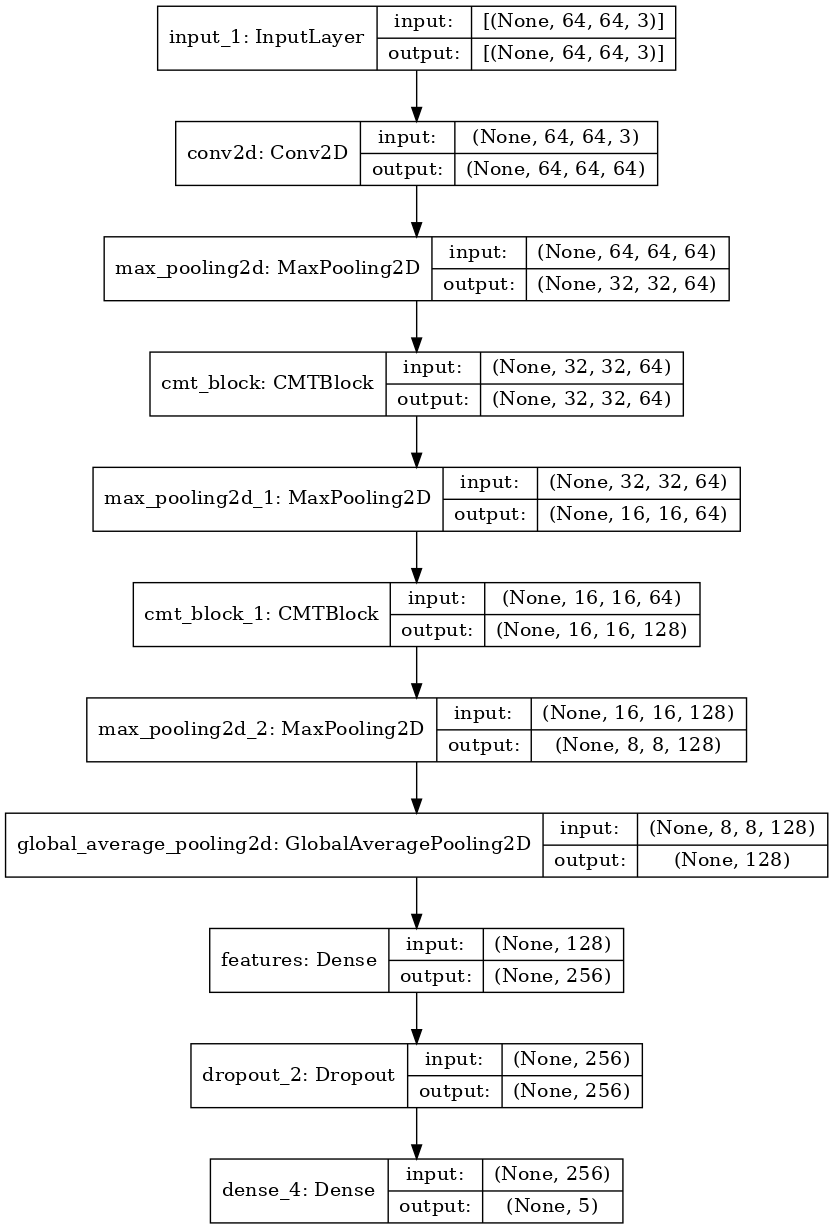

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=False, dpi=100)

In [7]:
# In 2 giá trị đầu tiên của train_features
print("train_features (first 2 samples):")
print(train_features[:2])

# In 2 giá trị đầu tiên của val_features
print("\nval_features (first 2 samples):")
print(val_features[:2])

# In 2 giá trị đầu tiên của test_features
print("\ntest_features (first 2 samples):")
print(test_features[:2])

# In 2 giá trị đầu tiên của y_train_lr
print("\ny_train_lr (first 2 labels):")
print(y_train_lr[:2])

# In 2 giá trị đầu tiên của y_val_lr
print("\ny_val_lr (first 2 labels):")
print(y_val_lr[:2])

# In 2 giá trị đầu tiên của y_test_lr
print("\ny_test_lr (first 2 labels):")
print(y_test_lr[:2])

# In 2 giá trị đầu tiên của val_preds_lr
print("\nval_preds_lr (first 2 predictions):")
print(val_preds_lr[:2])

# In 2 giá trị đầu tiên của test_preds_lr
print("\ntest_preds_lr (first 2 predictions):")
print(test_preds_lr[:2])


train_features (first 2 samples):
[[1.5502852  4.172076   0.02870525 0.         0.         0.0955489
  0.         0.         0.         0.09794875 0.         0.
  0.         0.         0.         0.         4.9328895  0.
  0.         0.         4.5044794  0.         0.         0.
  1.5957546  0.30593184 1.0100762  0.4904036  0.         1.2289685
  0.         0.         0.         0.         0.         0.44338724
  0.         0.         0.         3.649645   1.1255043  0.
  0.         0.         0.         1.8543203  0.         0.
  0.         0.         0.         1.8717868  0.         0.
  3.1326933  0.         0.1332026  1.2768853  1.3866719  1.076675
  0.         0.         0.         0.         0.         0.
  0.         1.8825219  0.         2.8524013  0.         1.7162316
  0.         0.21598327 0.         4.995357   0.656983   3.6862307
  0.         0.         1.215526   0.1826504  0.65593266 0.
  0.         2.0910273  0.6837207  0.         0.04655226 0.
  0.         0.         